In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from time import time

import seaborn as sns

['heart.csv']


References:
- https://www.kaggle.com/rgoodman/elo-merchant-with-no-peeking-at-other-kernels
- My ML Donors Udacity Project
- https://github.com/dmitriyboyuk/sl_classifier_framework-master/blob/master/finding_opportunity_segment_v1.ipynb

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("../input/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

In [4]:
skew_calcs = df.skew()
skew_calcs[abs(skew_calcs)>0.7]

sex        -0.791335
trestbps    0.713768
chol        1.143401
fbs         1.986652
exang       0.742532
oldpeak     1.269720
ca          1.310422
dtype: float64

In [5]:
skewed_features = skew_calcs[skew_calcs.abs()>0.7].index.tolist()
skewed_features

['sex', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'ca']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ee119f2e8>,
      dtype=object)

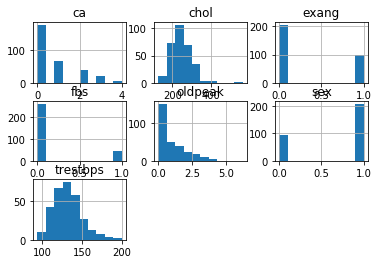

In [6]:
df[skewed_features].hist()

#### The distribution of log-transformed features does not appear to be significantly different, so I will stick with the original features provided

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6edd683eb8>,
      dtype=object)

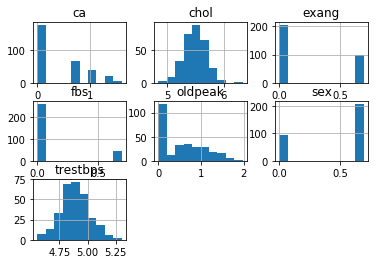

In [7]:
np.log1p(df[skewed_features]).hist()

## Prep Model for Training and Validation

In [8]:
from sklearn.model_selection import train_test_split
X, y = df.drop(['target'],axis = 1), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score

In [9]:
TP = np.sum(y) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = y.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [10]:
beta = .5
fscore = (1+beta**2)*(precision*recall)/((precision*beta**2)+recall)

In [11]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,.5)
    results['f_test'] = fbeta_score(y_test,predictions_test,.5)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

### Testing three models and viewing impact of sample size over time

In [12]:
samples_100 =  int(len(y_train)*1)
samples_10 = int(len(y_train)*.1)
samples_1 = int(len(y_train)*.01)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

clf_A = AdaBoostClassifier(random_state = 1)
clf_B = LogisticRegression(random_state = 1)
clf_C = RandomForestClassifier(random_state = 1)

In [13]:
def evaluate(results, accuracy, f1):
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

In [14]:
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

AdaBoostClassifier trained on 2 samples.
AdaBoostClassifier trained on 24 samples.
AdaBoostClassifier trained on 242 samples.
LogisticRegression trained on 2 samples.
LogisticRegression trained on 24 samples.
LogisticRegression trained on 242 samples.
RandomForestClassifier trained on 2 samples.
RandomForestClassifier trained on 24 samples.
RandomForestClassifier trained on 242 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


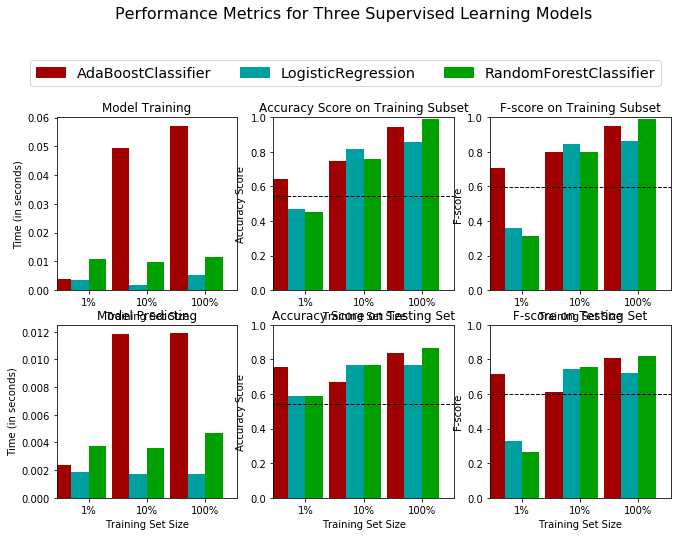

In [15]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

### Testing Multiple Models

In [16]:
learners= []

from sklearn.linear_model import LogisticRegression
learners.append(LogisticRegression())

from sklearn.tree import DecisionTreeClassifier
learners.append(DecisionTreeClassifier())

from sklearn.neighbors import KNeighborsClassifier
learners.append(KNeighborsClassifier())

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier 
learners.append(GradientBoostingClassifier())
learners.append(AdaBoostClassifier())
learners.append(BaggingClassifier())
learners.append(RandomForestClassifier())

from sklearn.svm import LinearSVC, SVC
learners.append(SVC())
learners.append(LinearSVC())

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
learners.append(BernoulliNB())
learners.append(GaussianNB())
learners.append(MultinomialNB())

results = {}
for clf in learners:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, int(len(y_train)), X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression trained on 242 samples.
DecisionTreeClassifier trained on 242 samples.
KNeighborsClassifier trained on 242 samples.
GradientBoostingClassifier trained on 242 samples.
AdaBoostClassifier trained on 242 samples.
BaggingClassifier trained on 242 samples.
RandomForestClassifier trained on 242 samples.
SVC trained on 242 samples.
LinearSVC trained on 242 samples.
BernoulliNB trained on 242 samples.
GaussianNB trained on 242 samples.
MultinomialNB trained on 242 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


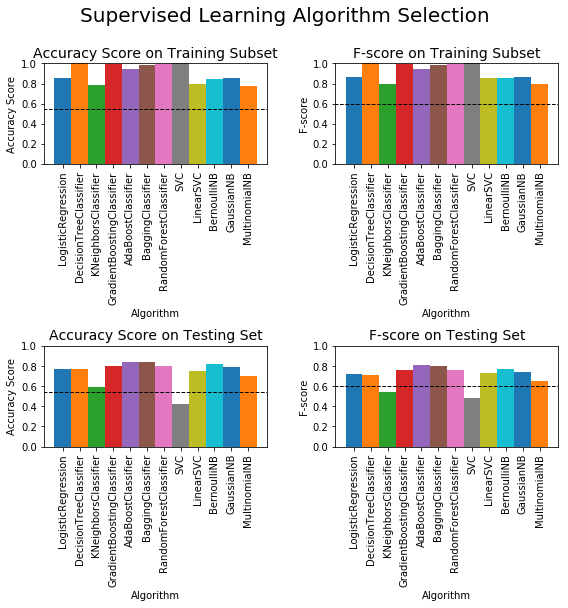

In [17]:
fig, ax = pl.subplots(2, 2, figsize = (8,8))

# Constants
bar_width = 1
font1 = 10
font2 = 14
font3 = 20

learners =[]
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['acc_train', 'f_train', 'acc_test', 'f_test']):

        # add x axis label
        ax[j//2, j%2].set_xlabel("Algorithm", fontsize = font1)  

        # Create plot
        ax[j//2, j%2].bar(k*bar_width, results[learner][metric], width = bar_width)
        ax[j//2, j%2].set_xticks(list(range(0,12)))

        # add labels and rotate them 90 degrees
        ax[j//2, j%2].set_xticklabels(list(results.keys())[:k+1],fontsize = font1) 
        for tick in ax[j//2, j%2].get_xticklabels():
            tick.set_rotation(90)

        # add x axis label
        ax[j//2, j%2].set_xlabel("Algorithm", fontsize = font1)          
        
ax[0, 0].set_ylabel("Accuracy Score", fontsize = font1)
ax[0, 1].set_ylabel("F-score", fontsize = font1)
ax[1, 0].set_ylabel("Accuracy Score", fontsize = font1)
ax[1, 1].set_ylabel("F-score", fontsize = font1)

# Add titles
ax[0, 0].set_title("Accuracy Score on Training Subset", fontsize = font2)
ax[0, 1].set_title("F-score on Training Subset", fontsize = font2)
ax[1, 0].set_title("Accuracy Score on Testing Set", fontsize = font2)
ax[1, 1].set_title("F-score on Testing Set", fontsize = font2)


# Add horizontal lines for naive predictors
ax[0, 0].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 0].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0, 1].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Set y-limits for score panels
ax[0, 0].set_ylim((0, 1))
ax[1, 0].set_ylim((0, 1))
ax[0, 1].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))

pl.suptitle("Supervised Learning Algorithm Selection", fontsize = font3, y = 1.05)
pl.tight_layout()
pl.show()

### It looks like AdaBoostClassifier has the best performance

In [18]:
model = AdaBoostClassifier()
model.fit(X,y)
model.feature_importances_
importances = model.feature_importances_

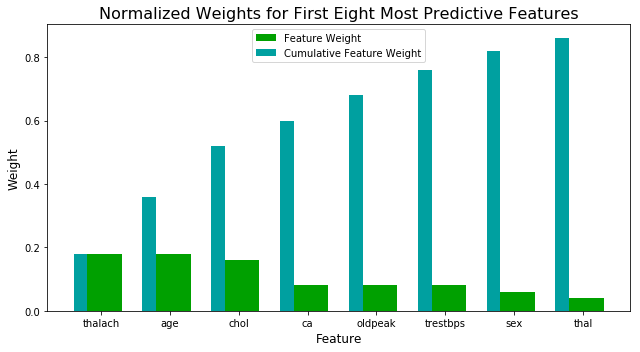

In [19]:
vars = 8
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:vars]]
values = importances[indices][:vars]
fig = pl.figure(figsize = (9,5))
pl.title("Normalized Weights for First Eight Most Predictive Features", fontsize = 16)
pl.bar(np.arange(vars), values, width = 0.6, align="center", color = '#00A000', \
      label = "Feature Weight")
pl.bar(np.arange(vars) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
      label = "Cumulative Feature Weight")
pl.xticks(np.arange(vars), columns)
pl.ylabel("Weight", fontsize = 12)
pl.xlabel("Feature", fontsize = 12)
pl.legend(loc = 'upper center')
pl.tight_layout()
pl.show()  

### We observe the distribution of the top three most important features and can confirm their clear differentiated distribution between target and non-target groups

In [20]:
target1 = df[df['target']==1]
target0 = df[df['target']==0]

thalach


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


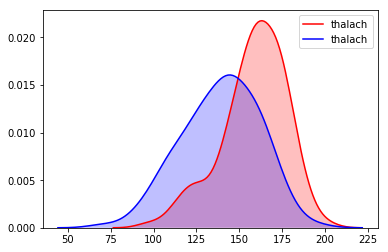

age


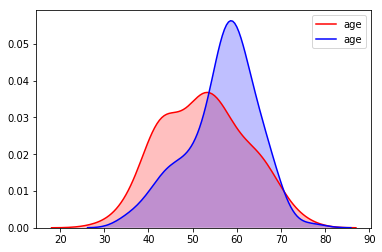

chol


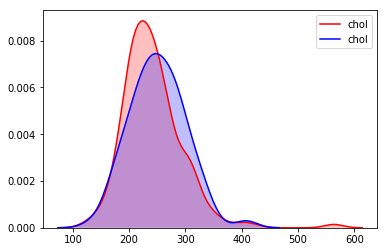

In [21]:
for i in columns[:3]:
    print(i)
    sns.kdeplot(data = target1[i],color = 'red',shade = True)
    sns.kdeplot(data = target0[i],color = 'blue',shade = True)
    plt.show()